### This is a practise for the Time Series Data Analysis for the London Energy Dataset

In [13]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# view the data 
df = pd.read_csv("london_energy.csv")

# sanity check
print(df.isna().sum())

# view the data 
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [15]:
# sanity check 
df.shape

(3510433, 3)

In [16]:
# sanity check 
df['Date'].nunique()

829

##### `LCLid` is a unique string that identifies each household, 
##### the `Date` is self-explanatory, 
##### the `KWH` is the total number of kilowatt-hours spent on that date
##### there are no missing values at all

In [17]:
df_avg_consumption = df.groupby("Date")["KWH"].mean() # gives mean for each date 
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"]) # convert colunmn from series to datetime object for TS analysis 
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")
# df_avg_consumption

,date,consumption
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805
...,...,...
824,2014-02-24,10.411403
825,2014-02-25,10.294997
826,2014-02-26,10.202945
827,2014-02-27,10.356350


<Axes: xlabel='date'>

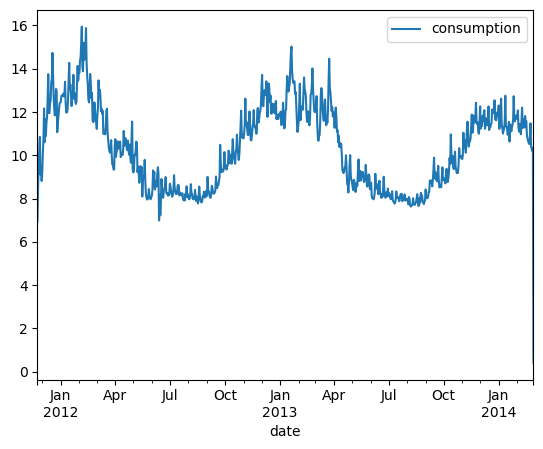

In [18]:
# We can have a look at the way consumption changes through the years
df_avg_consumption.plot(x="date", y="consumption")

##### The seasonality characteristic is pretty obvious. During the winter months we observe high demands in energy, while throughout the summer the consumption is at the lowest levels

<Axes: xlabel='date'>

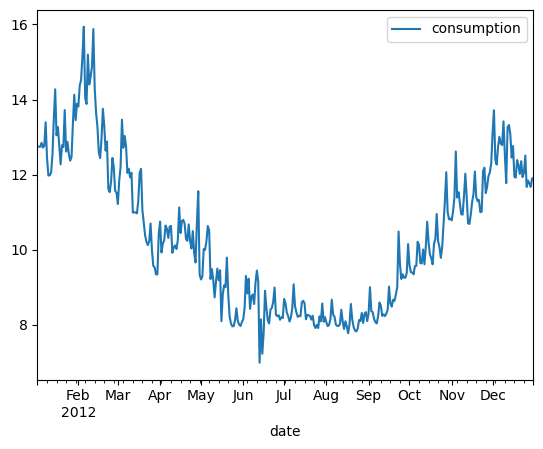

In [19]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")

##### To train a model like XGBoost and LightGB we need to create the features ourselves. Currently, we have only one feature: the full date. We can extract different features based on the full date such as the day of the week, the day of the year, the month and others.

In [20]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


##### So, the `date` feature is currently redundant. Before dropping it, we will use it to split our dataset into training and testing sets. Contrary to the conventional training, in time series we can’t just split the set in a random way because the order of the data is extremely important and we are only allowed to incorporate previous data. Otherwise, we might be prompted to predict a value while taking into consideration future values too! The dataset contains almost 2.5 years of data, so for the testing set we will use only the last 6 months.

In [21]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 7)
(216, 7)


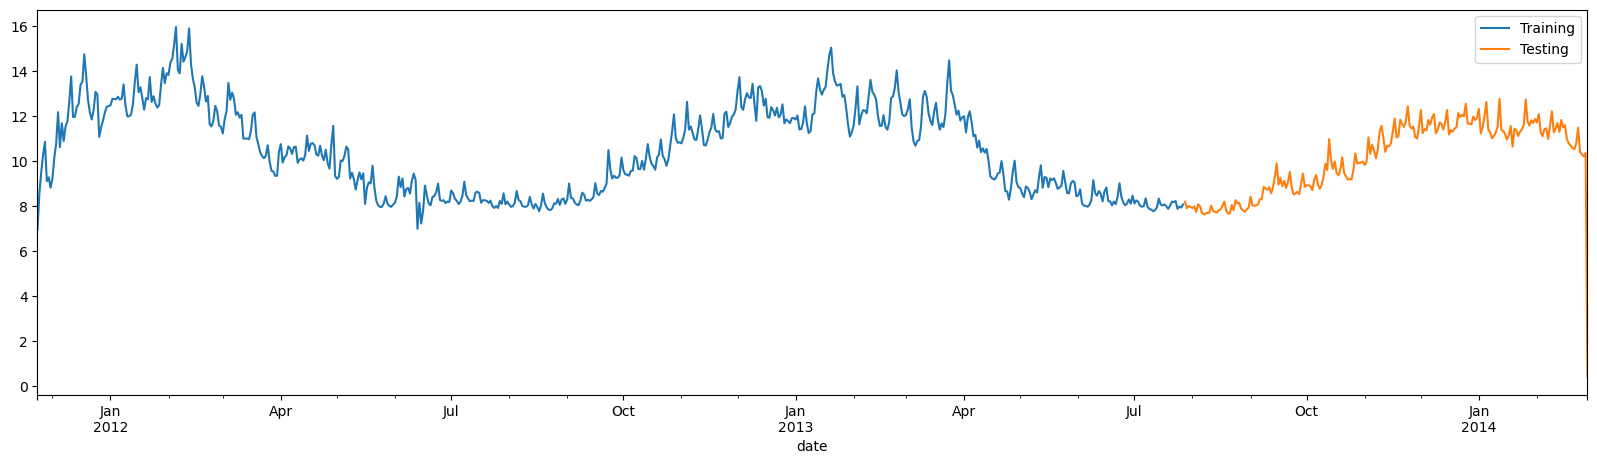

In [22]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

##### Now we can drop the `date` feature and create the training and testing sets:

In [23]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

##### The hyperparameter optimization will be done with grid search. The parameter configuration that achieves the best result, will be the one to form the best estimator. Grid search utilizes cross validation too, so it is crucial to provide an appropriate splitting mechanism.Again, due to the nature of the problem we can’t just use plain k-fold cross validation. Scikit learn provides the TimeSeriesSplit method which splits the data incrementally in a respectful manner in terms of continuity.

In [24]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

##### For the LightGB model we can do the same by providing different parameters:

In [25]:
# LGBM
"""
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)
"""

'\ncv_split = TimeSeriesSplit(n_splits=4, test_size=100)\nmodel = lgb.LGBMRegressor()\nparameters = {\n    "max_depth": [3, 4, 6, 5, 10],\n    "num_leaves": [10, 20, 30, 40, 100, 120],\n    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],\n    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],\n    "colsample_bytree": [0.3, 0.5, 0.7, 1]\n}\n\n\ngrid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)\ngrid_search.fit(X_train, y_train)\n'

##### For evaluation we will use Mean Absolute Error or MAE, the Mean Squared Error or MSE and the Mean Absolute Percentage Error or MAPE. Each of these provide a different perspective on the actual performance of the trained model. 

In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

##### Lastly, to evaluate any of the aforementioned models we have to run the following:

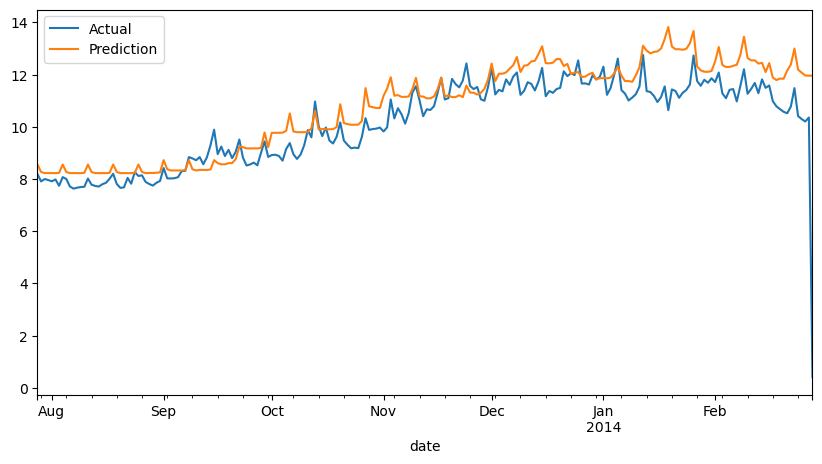

MAE: 0.726046583678707
MSE: 1.3039994731161895
MAPE: 0.19346012873545185


In [27]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

##### The model performs relatively well, but is there a way to improve it even further? The answer is yes. There are many different tips and tricks available that can be employed in order to achieve better results. One of them is to use auxiliary features that are correlated directly or indirectly to energy consumption. For example, the weather data can play a decisive role when it comes to predicting energy demands. In the next notebook I will add the weather data and re-run the models 